In [8]:
%%capture
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip
!pip install torchsummary
!pip install timm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

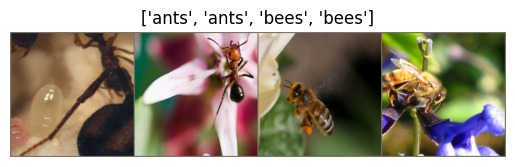

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc.item())


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc,val_loss,val_acc

In [5]:
def visualize_model_performance(train, val ,title):
  plt.plot([i+1 for i in range(len(train))],train,"-b", marker = 'o', label="train")
  plt.plot([i+1 for i in range(len(val))], val,"-r", marker = '*', label="val")
  plt.xlabel('Epochs')
  plt.ylabel(title)
  plt.title(title)
  plt.show()

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fine-tuning Pre-trained ResNet

In [7]:
# save and load models
model_ft = models.resnet18(weights="IMAGENET1K_V1")
PATH = "./resnet18_in1k.pth"
torch.save(model_ft.state_dict(), PATH)

# torch.save({"state_dict": model_ft.state_dict(), "optimizer": optimizer}, PATH)

In [8]:
# load saved model
checkpoint = torch.load(PATH)
print(checkpoint)

OrderedDict([('conv1.weight', tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2

In [9]:
# change key name 
# state_dict = {k.replace("backbone.", ""): v for k, v in checkpoint.items()}

# load model
model_ft = models.resnet18(weights=None)
print(model_ft.state_dict())

OrderedDict([('conv1.weight', tensor([[[[ 1.7241e-02,  5.6515e-02, -3.3670e-02,  ..., -1.5308e-02,
           -1.6385e-02,  3.3863e-02],
          [-3.0317e-02,  4.2028e-02, -1.0091e-02,  ...,  9.0785e-03,
            1.4860e-02, -9.5285e-03],
          [-1.6153e-02, -5.0807e-03, -2.6506e-02,  ..., -1.8103e-02,
            1.6183e-02, -1.2508e-02],
          ...,
          [-1.2824e-02, -4.0316e-02,  3.7344e-02,  ...,  6.1735e-03,
            3.8390e-02, -1.8310e-02],
          [-2.8085e-02,  6.8371e-04,  7.6741e-04,  ...,  1.5177e-02,
            3.5374e-03, -4.9665e-02],
          [ 1.7682e-02, -2.4558e-02, -1.0134e-02,  ...,  5.0432e-03,
            7.1237e-02, -1.7148e-02]],

         [[ 4.2099e-03,  1.1147e-02, -2.3242e-02,  ..., -1.7066e-03,
            6.7508e-03,  7.0367e-03],
          [-1.7731e-02,  1.2655e-02, -2.4282e-03,  ...,  4.3023e-03,
           -5.6800e-02, -6.0418e-02],
          [-2.2973e-04, -7.6330e-03,  1.5809e-02,  ...,  4.0609e-02,
           -1.1918e-02,  3.2

In [10]:
msg = model_ft.load_state_dict(checkpoint, strict=False)
print(msg)

<All keys matched successfully>


In [11]:
print(model_ft.state_dict())

OrderedDict([('conv1.weight', tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2

In [12]:
# check model definition with torchsummary lib
summary(model_ft.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [13]:
# directly check model definition with pytorch
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")

In [12]:
# define pre-trained model load from torchvision
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

NameError: name 'device' is not defined

In [9]:
model_ft,train_loss, train_acc,val_loss,val_acc = train_model(model_ft, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7075 Acc: 0.5533
val Loss: 0.5577 Acc: 0.7255

Epoch 1/24
----------
train Loss: 0.5553 Acc: 0.6844
val Loss: 0.3794 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4724 Acc: 0.7828
val Loss: 0.3356 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4748 Acc: 0.7664
val Loss: 0.2916 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4154 Acc: 0.8443
val Loss: 0.2567 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3945 Acc: 0.8361
val Loss: 0.2506 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3534 Acc: 0.8361
val Loss: 0.2411 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3110 Acc: 0.8770
val Loss: 0.2336 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3669 Acc: 0.8115
val Loss: 0.2340 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3830 Acc: 0.8279
val Loss: 0.2344 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3109 Acc: 0.8730
val Loss: 0.2096 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2939 Acc: 0.8689
val Loss: 0.2238 Acc: 0.9216

Ep

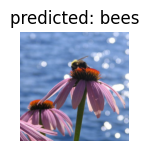

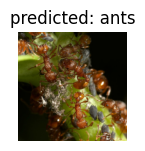

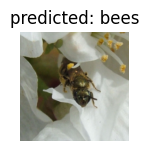

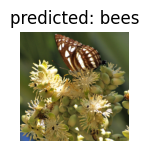

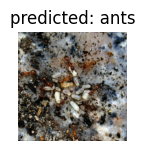

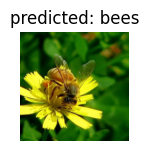

In [10]:
visualize_model(model_ft)

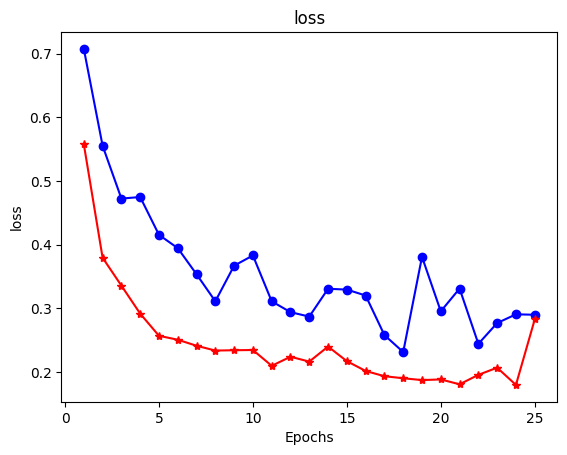

In [11]:
visualize_model_performance(train_loss, val_loss, 'loss')

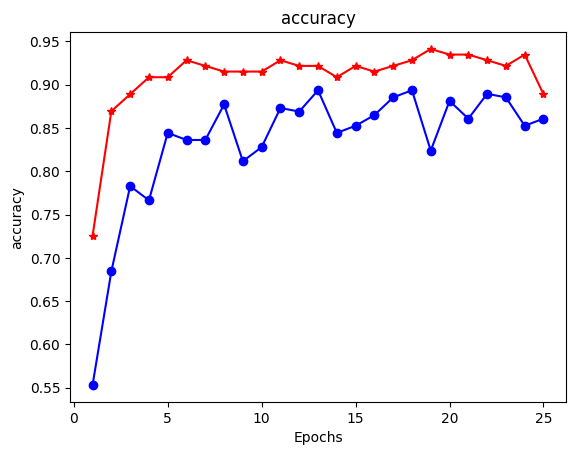

In [12]:
visualize_model_performance(train_acc, val_acc, 'accuracy')

## Pre-trained Model as Feature Extractor (Linear-Probing)

In [14]:
model_conv = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

for param in model_conv.fc.parameters():
    param.requires_grad = True
    
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.0001, momentum=0.9)

In [15]:
model_ft,train_loss, train_acc,val_loss,val_acc = train_model(model_conv, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7373 Acc: 0.4549
val Loss: 0.7678 Acc: 0.5163

Epoch 1/24
----------
train Loss: 0.7512 Acc: 0.4631
val Loss: 0.7725 Acc: 0.4902

Epoch 2/24
----------
train Loss: 0.7815 Acc: 0.4303
val Loss: 0.7666 Acc: 0.5359

Epoch 3/24
----------
train Loss: 0.7609 Acc: 0.4262
val Loss: 0.7706 Acc: 0.5098

Epoch 4/24
----------
train Loss: 0.7652 Acc: 0.4467
val Loss: 0.7672 Acc: 0.4837

Epoch 5/24
----------
train Loss: 0.7454 Acc: 0.4631
val Loss: 0.7534 Acc: 0.5163

Epoch 6/24
----------
train Loss: 0.7445 Acc: 0.4877
val Loss: 0.7728 Acc: 0.5098

Epoch 7/24
----------
train Loss: 0.7410 Acc: 0.4672
val Loss: 0.7762 Acc: 0.5098

Epoch 8/24
----------
train Loss: 0.7476 Acc: 0.4344
val Loss: 0.7533 Acc: 0.5490

Epoch 9/24
----------
train Loss: 0.7735 Acc: 0.3975
val Loss: 0.7747 Acc: 0.5033

Epoch 10/24
----------
train Loss: 0.7277 Acc: 0.4795
val Loss: 0.7799 Acc: 0.4967

Epoch 11/24
----------
train Loss: 0.7585 Acc: 0.4549
val Loss: 0.7856 Acc: 0.4902

Ep

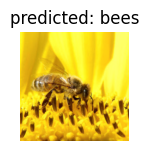

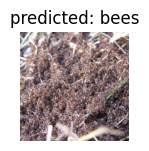

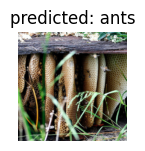

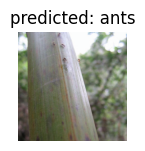

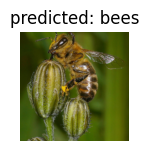

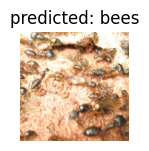

In [16]:
visualize_model(model_ft)

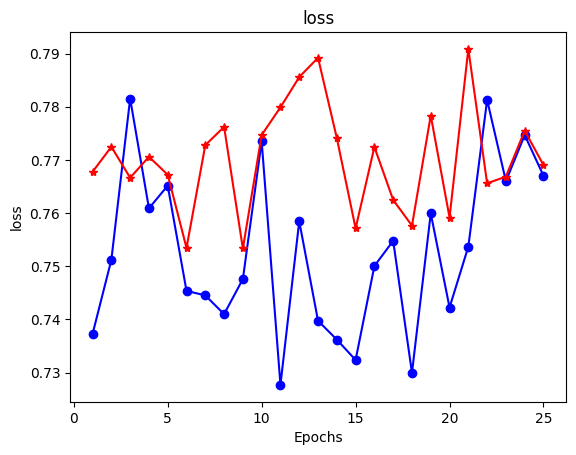

In [17]:
visualize_model_performance(train_loss, val_loss, 'loss')

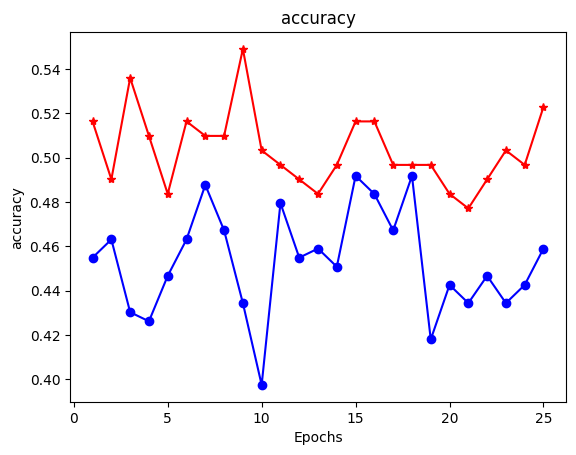

In [18]:
visualize_model_performance(train_acc,val_acc,'accuracy')

## Random Initialisation (Not-Pretrained)

In [19]:
model_conv = torchvision.models.resnet18(pretrained=False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

D:\AnacondaInstalled\envs\python3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\AnacondaInstalled\envs\python3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
model_ft,train_loss, train_acc,val_loss,val_acc = train_model(model_conv, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7012 Acc: 0.4672
val Loss: 0.7048 Acc: 0.4771

Epoch 1/24
----------
train Loss: 0.6940 Acc: 0.5287
val Loss: 0.7077 Acc: 0.4641

Epoch 2/24
----------
train Loss: 0.6935 Acc: 0.5082
val Loss: 0.7133 Acc: 0.4314

Epoch 3/24
----------
train Loss: 0.6967 Acc: 0.5287
val Loss: 0.7148 Acc: 0.4771

Epoch 4/24
----------
train Loss: 0.6964 Acc: 0.5246
val Loss: 0.7074 Acc: 0.4837

Epoch 5/24
----------
train Loss: 0.6972 Acc: 0.4713
val Loss: 0.7152 Acc: 0.4314

Epoch 6/24
----------
train Loss: 0.6943 Acc: 0.5164
val Loss: 0.7134 Acc: 0.4771

Epoch 7/24
----------
train Loss: 0.6997 Acc: 0.4795
val Loss: 0.7099 Acc: 0.4314

Epoch 8/24
----------
train Loss: 0.6933 Acc: 0.5000
val Loss: 0.7142 Acc: 0.4641

Epoch 9/24
----------
train Loss: 0.6920 Acc: 0.5410
val Loss: 0.7099 Acc: 0.4706

Epoch 10/24
----------
train Loss: 0.6919 Acc: 0.5574
val Loss: 0.7164 Acc: 0.4837

Epoch 11/24
----------
train Loss: 0.6939 Acc: 0.5082
val Loss: 0.7082 Acc: 0.4641

Ep

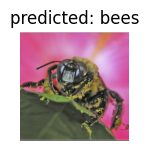

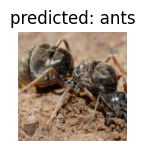

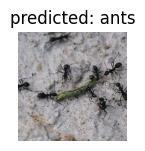

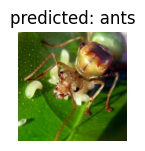

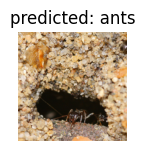

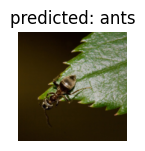

In [21]:
visualize_model(model_ft)

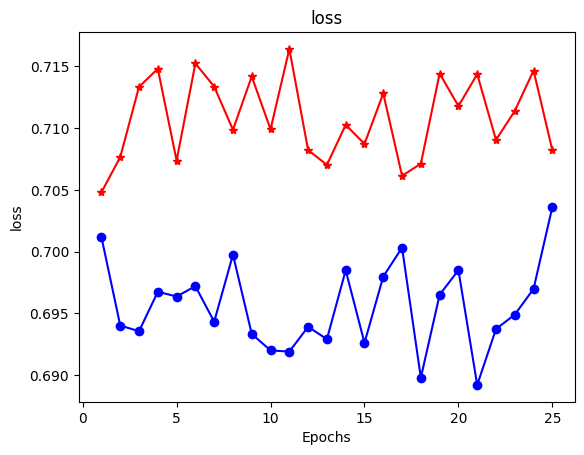

In [22]:
visualize_model_performance(train_loss, val_loss, 'loss')

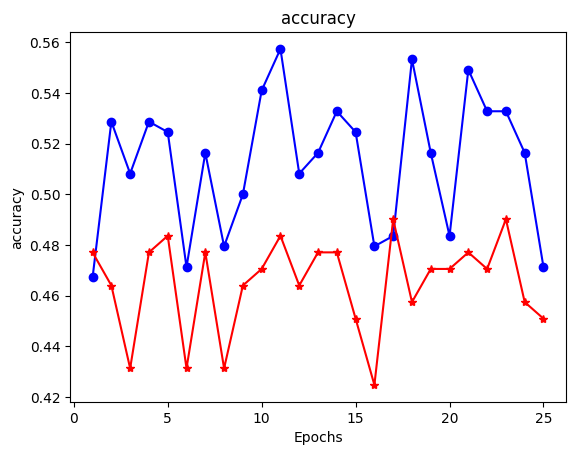

In [23]:
visualize_model_performance(train_acc,val_acc,'accuracy')

# Fine-tuning Pre-trained ViT (Pre-trained on ImageNet 21k)

In [24]:
import timm

model_vit = timm.create_model('vit_base_patch16_224_in21k', pretrained=True)
model_vit.head = torch.nn.Linear(768, 2)

In [25]:
model_vit

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=F

In [26]:
model_vit = model_vit.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_vit = optim.SGD(model_vit.parameters(), lr=0.0001, momentum=0.9)

In [27]:
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(model_vit, criterion, optimizer_vit, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8549 Acc: 0.7213
val Loss: 0.6685 Acc: 0.7059

Epoch 1/24
----------
train Loss: 0.8501 Acc: 0.6721
val Loss: 0.4176 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.5608 Acc: 0.7910
val Loss: 0.8942 Acc: 0.6536

Epoch 3/24
----------
train Loss: 0.3143 Acc: 0.8934
val Loss: 0.1917 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.1904 Acc: 0.9426
val Loss: 0.2519 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.1473 Acc: 0.9549
val Loss: 0.3146 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.1150 Acc: 0.9672
val Loss: 0.2794 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.0635 Acc: 0.9795
val Loss: 0.2604 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.0501 Acc: 0.9877
val Loss: 0.3047 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.1338 Acc: 0.9631
val Loss: 0.2524 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.0884 Acc: 0.9631
val Loss: 0.2296 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0359 Acc: 0.9877
val Loss: 0.1761 Acc: 0.9412

Ep

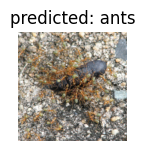

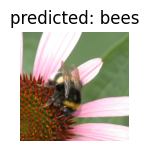

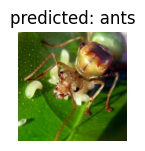

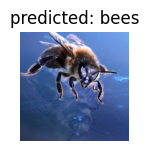

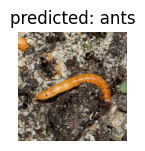

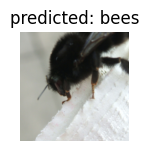

In [28]:
visualize_model(model_ft)

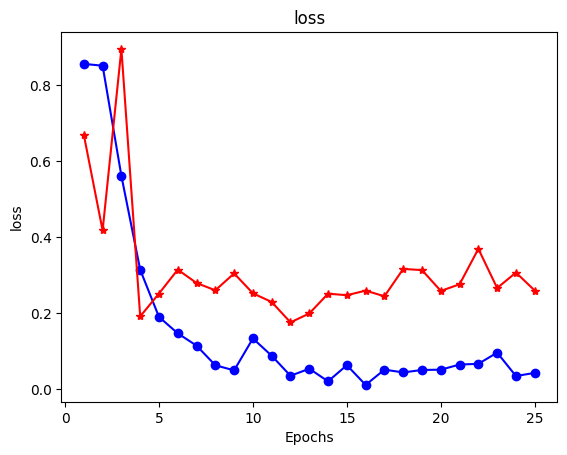

In [29]:
visualize_model_performance(train_loss, val_loss, 'loss')

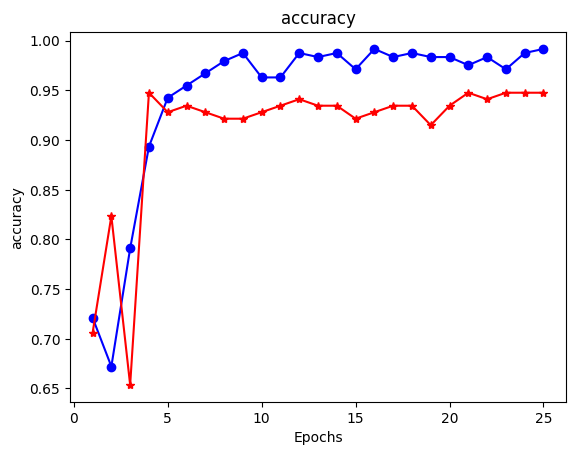

In [30]:
visualize_model_performance(train_acc, val_acc, 'accuracy')